1. Classify ImageNEt and Dogs images by confidence intervals, remove low-quality images, remove MINDs
2. Generate explanations for COnf, GradCAM, SHAP, 3-NN
3. Generate samples images and intro images for Dogs and ImageNet
4. Generate visualizations for Gorilla Instructions
5. Generate validation image aggregations, class samples, ImageNEt/Dogs distribution for paper writing

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision

from torchvision.models import *
from visualisation.core.utils import device, image_net_postprocessing, image_net_preprocessing
from torch import nn
from operator import itemgetter
from visualisation.core.utils import imshow

import xml.etree.ElementTree as ET
import random
import os
from torchvision import models
from shutil import copyfile, rmtree
import glob
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from PIL import Image
from IPython.core.debugger import Tracer

plt.rcParams["figure.figsize"]= 16,8


from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *

size= 224

# Pre-process the image and convert into a tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
])

In [2]:
def make_dir(path):
    if os.path.isdir(path) == False:
        os.mkdir(path)

# Added for loading ImageNet classes
def load_imagenet_label_map():
    """
    Load ImageNet label dictionary.
    return:
    """

    input_f = open("input_txt_files/imagenet_classes.txt")
    label_map = {}
    for line in input_f:
        parts = line.strip().split(": ")
        (num, label) = (int(parts[0]), parts[1].replace('"', ""))
        label_map[num] = label

    input_f.close()
    return label_map


# Added for loading ImageNet classes
def load_imagenet_id_map():
    """
    Load ImageNet ID dictionary.
    return;
    """

    input_f = open("input_txt_files/synset_words.txt")
    label_map = {}
    for line in input_f:
        parts = line.strip().split(" ")
        (num, label) = (parts[0], ' '.join(parts[1:]))
        label_map[num] = label

    input_f.close()
    return label_map

def load_imagenet_validation_gt():
    count = 0
    input_f = open("input_txt_files/ILSVRC2012_validation_ground_truth.txt")
    gt_dict = {}
    while True:
        count += 1
        
        # Get the next line
        line = input_f.readline()
        
        # if line is empty, EOL is reached
        if not line:
            break
        gt_dict [count] = int(line.strip())

    input_f.close()
    return gt_dict

def convert_imagenet_label_to_id(label_map, key_list, val_list, prediction_class):
    """
    Convert imagenet label to ID: for example - 245 -> "French bulldog" -> n02108915
    :param label_map:
    :param key_list:
    :param val_list:
    :param prediction_class:
    :return:
    """
    class_to_label = label_map[prediction_class]
    prediction_id = key_list[val_list.index(class_to_label)]
    return prediction_id

gt_dict = load_imagenet_validation_gt()
id_map = load_imagenet_id_map()
label_map = load_imagenet_label_map()

key_list = list(id_map.keys())
val_list = list(id_map.values())

print(key_list[200])

def convert_imagenet_id_to_label(key_list, class_id):
    """
    Convert imagenet label to ID: for example - n02108915 -> "French bulldog" -> 245
    :param label_map:
    :param key_list:
    :param val_list:
    :param prediction_class:
    :return:
    """
    return key_list.index(str(class_id))

n02097474


In [1]:
def load_imagenet_dog_label():
    count = 0
    dog_id_list = list()
    input_f = open("input_txt_files/dog_type.txt")
    for line in input_f:
        dog_id = (line.split('-')[0])
        dog_id_list.append(dog_id)
    return dog_id_list

dogs_id = load_imagenet_dog_label()


In [4]:
############# Prepare images for all experiments
UPPER_THRESH = 0.8
LOWER_THRESH = 0.2

NAT_DATASET_TRAIN_INTERVAL = '/home/dexter/Downloads/Dataset/Interval_train_nat/'
DOG_DATASET_TRAIN_INTERVAL = '/home/dexter/Downloads/Dataset/Interval_train_dog/'
NAT_DATASET_INTERVAL = '/home/dexter/Downloads/Dataset/Interval_nat/'
DOG_DATASET_INTERVAL = '/home/dexter/Downloads/Dataset/Interval_dog/'
ADV_NAT_INTERVAL = '/home/dexter/Downloads/Dataset/Interval_adv_nat/'
ADV_DOG_INTERVAL = '/home/dexter/Downloads/Dataset/Interval_adv_dog/'

NAT_RESNET34_CORRECT = '/home/dexter/Downloads/Dataset/Natural_correct_resnet34/'
NAT_RESNET34_WRONG = '/home/dexter/Downloads/Dataset/Natural_wrong_resnet34/'
NAT_RESNET34_HARD = '/home/dexter/Downloads/Dataset/Natural_hard_images_resnet34/'
NAT_RESNET34_EASY = '/home/dexter/Downloads/Dataset/Natural_easy_images_resnet34/'
NAT_ADV_RESNET34 = '/home/dexter/Downloads/Dataset/Natural_Adv_images_resnet34/'
NAT_RESNET34_CORRECT_UPPER_THRESH = '/home/dexter/Downloads/Dataset/Natural_correct_resnet34_above_08/'
NAT_RESNET34_CORRECT_LOWER_THRESH = '/home/dexter/Downloads/Dataset/Natural_correct_resnet34_below_02/'
NAT_RESNET34_WRONG_UPPER_THRESH = '/home/dexter/Downloads/Dataset/Natural_wrong_resnet34_above_08/'
NAT_RESNET34_WRONG_LOWER_THRESH = '/home/dexter/Downloads/Dataset/Natural_wrong_resnet34_below_02/'
NAT_ATTACKED = '/home/dexter/Downloads/Dataset/Adv_nat_examples/'
NAT_ATTACKED_VERIFIED = '/home/dexter/Downloads/Dataset/Adv_nat_examples_verified/'

DOG_RESNET34_CORRECT = '/home/dexter/Downloads/Dataset/Dog_correct_resnet34/'
DOG_RESNET34_WRONG = '/home/dexter/Downloads/Dataset/Dog_wrong_resnet34/'
DOG_RESNET34_HARD = '/home/dexter/Downloads/Dataset/Dog_hard_images_resnet34/'
DOG_RESNET34_EASY = '/home/dexter/Downloads/Dataset/Dog_easy_images_resnet34/'
DOG_ADV_RESNET34 = '/home/dexter/Downloads/Dataset/Dog_Adv_images_resnet34/'
DOG_RESNET34_CORRECT_UPPER_THRESH = '/home/dexter/Downloads/Dataset/Dog_correct_resnet34_above_08/'
DOG_RESNET34_CORRECT_LOWER_THRESH = '/home/dexter/Downloads/Dataset/Dog_correct_resnet34_below_02/'
DOG_RESNET34_WRONG_UPPER_THRESH = '/home/dexter/Downloads/Dataset/Dog_wrong_resnet34_above_08/'
DOG_RESNET34_WRONG_LOWER_THRESH = '/home/dexter/Downloads/Dataset/Dog_wrong_resnet34_below_02/'
DOG_ATTACKED = '/home/dexter/Downloads/Dataset/Adv_dog_examples/'
DOG_ATTACKED_VERIFIED = '/home/dexter/Downloads/Dataset/Adv_dog_examples_verified/'

In [ ]:
# Classify ImageNet and Dogs by confidence interval.Remove low-quality images, MIND samples
model = resnet34(pretrained=True).to(device)
model.eval()

from shutil import copyfile
dog_flag = True

imagenet_folders = glob.glob('/home/dexter/Downloads/train/*')
if dog_flag:
    dataset_path = DOG_DATASET_TRAIN_INTERVAL
else:
    dataset_path = NAT_DATASET_TRAIN_INTERVAL
make_dir(dataset_path)
correct = 0
wrong = 0
indomain_wrong = 0
for i, imagenet_folder in enumerate(imagenet_folders):
    print(i)
    imagenet_id = imagenet_folder.split('train/')[1]

    if dog_flag:
        if imagenet_id not in dogs_id:
            continue

    image_paths = glob.glob(imagenet_folder + '/*.*')
    for idx, image_path in enumerate(image_paths):
        if idx == 50:
            break
        img = Image.open(image_path)
        if img.mode != 'RGB' or img.size[0] < 224 or img.size[1] < 224:
            continue
        x = transform(img).unsqueeze(0).to(device)
        out = model(x)
        p = torch.nn.functional.softmax(out, dim=1)
        score, index = torch.topk(p, 1)
        confidence_score = score[0][0].item()
        predicted_confidence = ("%.2f") %(confidence_score)
        category_id = int(index[0][0].item())
        prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, category_id)

        conf_interval = str(int(confidence_score*10))
        if int(confidence_score*10) == 10:
            conf_interval = str(9)
        if prediction_id == imagenet_id:
            correct +=1
            if os.path.isdir(dataset_path + 'correct_' + conf_interval + '/') == False:
                os.mkdir(dataset_path + 'correct_' + conf_interval + '/')
            dst_file = dataset_path + 'correct_' + conf_interval + '/' + prediction_id + '_' + image_path.split(imagenet_id + '/')[1].split('.JPEG')[0] + '_' + imagenet_id + '.jpeg'
        else:
            wrong +=1
            # Ensure the prediction is in dog ids
            if dog_flag:
                if prediction_id not in dogs_id:
                    continue
                else:
                    indomain_wrong += 1
            if os.path.isdir(dataset_path + 'wrong_' + conf_interval + '/') == False:
                os.mkdir(dataset_path + 'wrong_' + conf_interval + '/')
            dst_file = dataset_path + 'wrong_' + conf_interval + '/' + prediction_id + '_' + image_path.split(imagenet_id + '/')[1].split('.JPEG')[0] + '_' + imagenet_id + '.jpeg'
        copyfile(image_path, dst_file)


print([correct, wrong])
print(indomain_wrong)

In [ ]:
# Generate Confidence explanations
import cv2 as cv
method = 'Conf'
# test_image_paths = corrects_bin1[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     wrongs_bin1[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     corrects_bin2[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     wrongs_bin2[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     corrects_bin3[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     wrongs_bin3[methods.index(method)*img_num:methods.index(method)*img_num + img_num]
# test_image_paths = ['/home/dexter/Downloads/Dataset/Interval_train_nat/correct_0/n03250847_n03250847_8348_n03250847.jpeg']

test_image_paths = glob.glob('/home/dexter/Downloads/Human_experiments/Training/*.*')
# Tracer()()
# for idx, image_path in enumerate(test_image_paths[methods.index(method)*img_num:methods.index(method)*img_num + img_num]):
for idx, image_path in enumerate(test_image_paths):
    print(idx + 1)
    distance_dict = dict()
    neighbors = list()
    categories_confidences = list()
    confidences= list ()

    img = Image.open(image_path)

    input_image = img.resize((size,size), Image.ANTIALIAS)
    image_name = (image_path.split('.jpeg')[0]).split('Training/')[1]
    print(image_name)

    # Get the ground truth of the input image
    gt_label_id = image_path[-14:-5]
    
    gt_label = id_map.get(gt_label_id)
    id = key_list.index(gt_label_id)
    gt_label = gt_label.split(',')[0]



    # Get the prediction for the input image
    img = Image.open(image_path)
    x = transform(img).unsqueeze(0).to(device)
    out = model(x)
    p = torch.nn.functional.softmax(out, dim=1)
    score, index = torch.topk(p, 1)
    input_category_id = index[0][0].item()
    predicted_confidence = score[0][0].item()
    predicted_confidence = ("%.2f") %(predicted_confidence)
#     print(predicted_confidence)


    input_prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, input_category_id)
    predicted_label = id_map.get(input_prediction_id).split(',')[0]
    predicted_label = predicted_label[0].lower() + predicted_label[1:]

    # Original image
    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('{}% {}'.format(int(float(predicted_confidence)*100), predicted_label))
    plt.imshow(input_image)
#     plt.imshow(modified_img[idx])
    plt.savefig('tmp/original.jpeg', bbox_inches='tight')
    plt.close()


    img = cv.resize(cv.imread(image_path,0),((size,size)))
    edges = cv.Canny(img,100,200)
    edges = edges - 255

    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.imshow(edges, cmap = 'gray')
    plt.savefig('tmp/Edge.jpeg', bbox_inches='tight')
    plt.close()

#     Confidence score only
    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('{}: {}'.format(predicted_label, predicted_confidence))
    plt.imshow(input_image)
    plt.savefig('/home/dexter/Downloads/Human_experiments/Training/{}/{}.jpeg'.format(method, image_name), bbox_inches='tight', dpi=300)
    plt.close()


In [ ]:
# Generate GradCAM explanations

from torchray.attribution.grad_cam import grad_cam
method = 'GradCAM'
## Creating colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
uP = cm.get_cmap('Reds', 129)
dowN = cm.get_cmap('Blues_r', 128)
newcolors = np.vstack((
    dowN(np.linspace(0, 1, 128)),
    uP(np.linspace(0, 1, 129))
))
cMap = ListedColormap(newcolors, name='RedBlues')
cMap.colors[257 // 2, :] = [1, 1, 1, 1]

test_image_paths = glob.glob('/home/dexter/Downloads/Human_experiments/Training/*.*')

# for idx, image_path in enumerate(test_image_paths[methods.index(method)*img_num:methods.index(method)*img_num + img_num]):
for idx, image_path in enumerate(test_image_paths):
    print(idx + 1)
    distance_dict = dict()
    neighbors = list()
    categories_confidences = list()
    confidences= list ()
    img = Image.open(image_path)
#     print(test_image_paths[idx])
    input_image = img.resize((size,size), Image.ANTIALIAS)
    image_name = (image_path.split('.jpeg')[0]).split('Training/')[1]
    print(image_name)

    # Get the ground truth of the input image
    gt_label_id = image_path[-14:-5]

    
    gt_label = id_map.get(gt_label_id)
    id = key_list.index(gt_label_id)
    gt_label = gt_label.split(',')[0]


    # Get the prediction for the input image
    img = Image.open(image_path)
    x = transform(img).unsqueeze(0).to(device)
    out = model(x)
    p = torch.nn.functional.softmax(out, dim=1)
    score, index = torch.topk(p, 1)
    input_category_id = index[0][0].item()
    predicted_confidence = score[0][0].item()
    predicted_confidence = ("%.2f") %(predicted_confidence)
#     print(predicted_confidence)


    input_prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, input_category_id)
    predicted_label = id_map.get(input_prediction_id).split(',')[0]
    predicted_label = predicted_label[0].lower() + predicted_label[1:]

    # Original image
    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('{}% {}'.format(int(float(predicted_confidence)*100), predicted_label))
    plt.imshow(input_image)
#     plt.imshow(modified_img[idx])
    plt.savefig('tmp/original.jpeg', bbox_inches='tight')
    plt.close()

    img = cv.resize(cv.imread(image_path,0),((size,size)))
    edges = cv.Canny(img,100,200)
    edges = edges - 255

    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.imshow(edges, cmap = 'gray')
    plt.savefig('tmp/Edge.jpeg', bbox_inches='tight')
    plt.close()
    

#     GRAD-CAM
    saliency = grad_cam(
        model, x, input_category_id,
        saliency_layer='layer4',
        resize=True
    )

    saliency_path = 'saliency_maps/GradCAM_resnet34/'
    saliency *= 1.0/saliency.max()
    GradCAM = saliency[0][0].cpu().detach().numpy()

    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('Explanation')
    plt.imshow(GradCAM, cmap=cMap, vmin=0, vmax=1)
    plt.colorbar(orientation='vertical')
    plt.savefig('tmp/heatmap.jpeg', bbox_inches='tight')
    plt.close()

    # Get overlay version
    myCmd = 'composite -blend 10 Edge.jpeg -gravity SouthWest heatmap.jpeg overlay.jpeg'
    os.system(myCmd)

    img_path = '/home/dexter/Downloads/Human_experiments/Training/{}/{}.jpeg'.format(method, image_name)
    myCmd = 'montage original.jpeg overlay.jpeg -tile 2x1 -geometry +0+0 ' + img_path
    print(myCmd)
    os.system(myCmd)

In [ ]:
# Generate SHAP explanations

import shap
import json
##########################################
bg_image_paths = glob.glob('/home/dexter/Downloads/Dataset/bg/*.*')
bg_inputs = list(map(lambda x: Image.open(x), bg_image_paths))
bg_inputs = [transform(x).unsqueeze(0) for x in bg_inputs]
bg_inputs = [i.to(device) for i in bg_inputs]

background = torch.cat(bg_inputs[:100])
background = background.detach()

e = shap.DeepExplainer(model, background)

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

method = 'SHAP'
# SHAP

# for idx, image_path in enumerate(test_image_paths[methods.index(method)*img_num:methods.index(method)*img_num + img_num]):
for idx, image_path in enumerate(test_image_paths):
    print(idx + 1)
    distance_dict = dict()
    neighbors = list()
    categories_confidences = list()
    confidences= list ()
    img = Image.open(image_path)
    
#     print(test_image_paths[idx])
    input_image = img.resize((size,size), Image.ANTIALIAS)
    image_name = (image_path.split('.jpeg')[0]).split('Training/')[1]
    print(image_name)

    gt_label_id = image_path[-14:-5]

    gt_label = id_map.get(gt_label_id)
    id = key_list.index(gt_label_id)
    gt_label = gt_label.split(',')[0]


    # Get the prediction for the input image
    img = Image.open(image_path)
    x = transform(img).unsqueeze(0).to(device)
    out = model(x)
    p = torch.nn.functional.softmax(out, dim=1)
    score, index = torch.topk(p, 1)
    input_category_id = index[0][0].item()
    predicted_confidence = score[0][0].item()
    predicted_confidence = ("%.2f") %(predicted_confidence)
#     print(predicted_confidence)


    input_prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, input_category_id)
    predicted_label = id_map.get(input_prediction_id).split(',')[0]
    predicted_label = predicted_label[0].lower() + predicted_label[1:]

    # Original image
    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('{}% {}'.format(int(float(predicted_confidence)*100), predicted_label))
    plt.imshow(input_image)
#     plt.imshow(modified_img[idx])
    plt.savefig('tmp/original.jpeg', bbox_inches='tight')
    plt.close()

    img = cv.resize(cv.imread(image_path,0),((size,size)))
    edges = cv.Canny(img,100,200)
    edges = edges - 255

    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.imshow(edges, cmap = 'gray')
    plt.savefig('tmp/Edge.jpeg', bbox_inches='tight')
    plt.close()
    

    test_images = Image.open(image_path)
    test_images = [transform(test_images).unsqueeze(0)]
    test_images = [i.to(device) for i in test_images]

    test_images_t = torch.cat(test_images)
    shap_values = e.shap_values(test_images_t, ranked_outputs=1, output_rank_order='max') # 2xranked_outputsx1x3x224x224

    square_img = np.sum(shap_values[0][0][0], axis=0)
    min_val = square_img.min()
    max_val = square_img.max()
    if (-1*min_val) > max_val:
        max_val = -1.0*min_val

    square_img *= 1.0/max_val
    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('Explanation')
    plt.imshow(square_img, cmap=cMap, vmin=0, vmax=1)

    plt.colorbar(orientation='vertical')
    plt.savefig('tmp/heatmap.jpeg', bbox_inches='tight')
    plt.close()

    # Get overlay version
    myCmd = 'composite -blend 10 tmp/Edge.jpeg -gravity SouthWest tmp/heatmap.jpeg tmp/overlay.jpeg'
    os.system(myCmd)

    img_path = '/home/dexter/Downloads/Human_experiments/Training/{}/{}.jpeg'.format(method, image_name)
    myCmd = 'montage tmp/original.jpeg tmp/overlay.jpeg -tile 2x1 -geometry +0+0 ' + img_path
    os.system(myCmd)

In [ ]:
# Generate 3-NN explanations

imagenet_train_path = '/home/dexter/Downloads/train'
K = 3
layer = 4
feature_extractor = nn.Sequential(*list(model.children())[:layer-6])
method = 'NNs'
# NNs

test_image_paths = glob.glob('/home/dexter/Downloads/Human_experiments/Training/*.*')

# for idx, image_path in enumerate(test_image_paths[methods.index(method)*img_num:methods.index(method)*img_num + img_num]):
for idx, image_path in enumerate(test_image_paths):
    print(idx + 1)
    distance_dict = dict()
    neighbors = list()
    categories_confidences = list()
    confidences= list ()
    img = Image.open(image_path)
    
    if 1:
        embedding = feature_extractor(transform(img).unsqueeze(0).to(device)).flatten(start_dim=1) 
#     print(test_image_paths[idx])
    input_image = img.resize((size,size), Image.ANTIALIAS)
    image_name = (image_path.split('.jpeg')[0]).split('Training/')[1]
    print(image_name)

    # Get the ground truth of the input image
    gt_label_id = image_path[-14:-5]

    gt_label = id_map.get(gt_label_id)
    id = key_list.index(gt_label_id)
    gt_label = gt_label.split(',')[0]


    # Get the prediction for the input image
    img = Image.open(image_path)
    x = transform(img).unsqueeze(0).to(device)
    out = model(x)
    p = torch.nn.functional.softmax(out, dim=1)
    score, index = torch.topk(p, 1)
    input_category_id = index[0][0].item()
    predicted_confidence = score[0][0].item()
    predicted_confidence = ("%.2f") %(predicted_confidence)

    input_prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, input_category_id)
    predicted_label = id_map.get(input_prediction_id).split(',')[0]
    predicted_label = predicted_label[0].lower() + predicted_label[1:]

    # Original image
    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('{}% {}'.format(int(float(predicted_confidence)*100), predicted_label))
    plt.imshow(input_image)
#     plt.imshow(modified_img[idx])
    plt.savefig('tmp/original.jpeg', bbox_inches='tight')
    plt.close()

    img = cv.resize(cv.imread(image_path,0),((size,size)))
    edges = cv.Canny(img,100,200)
    edges = edges - 255

    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.imshow(edges, cmap = 'gray')
    plt.savefig('tmp/Edge.jpeg', bbox_inches='tight')
    plt.close()
    
    if 1:
        from utils import *
        ## Nearest Neighbors

        predicted_set_path = os.path.join(imagenet_train_path, input_prediction_id)
        predicted_set_img_paths = glob.glob(predicted_set_path + '/*.*')
        predicted_set_color_images= list()

        embedding = embedding.detach()
        embedding.to(device)
        # Build search space for nearest neighbors
        for i, path in enumerate(predicted_set_img_paths):
            img = Image.open(path)
            if img.mode != 'RGB':
                img.close()
                del img
                continue

            x = transform(img).unsqueeze(0).to(device)
            out = model(x)
            p = torch.nn.functional.softmax(out, dim=1)
            del out
            score, index = torch.topk(p, 1)
            del p
            category_id = index[0][0].item()
            del score, index
            
            # This is to avoid the confusion from crane 134 and crane 517 and to make NNs work :)
            if input_category_id != category_id:
                continue

            f = feature_extractor(x)
            feature_vector = f.flatten(start_dim=1).to(device)
            feature_vector = feature_vector.detach()

            del f
            distance_dict[path] = torch.dist(embedding, feature_vector)

            del feature_vector 
            torch.cuda.empty_cache()
            img.close()
            del img
            predicted_set_color_images.append(path)

        # Get K most similar images
        res = dict(sorted(distance_dict.items(), key = itemgetter(1))[:K]) 
        print("Before...")
        print(res)
        while distance_dict[list(res.keys())[0]] < 100:
            del distance_dict[list(res.keys())[0]]
            res = dict(sorted(distance_dict.items(), key = itemgetter(1))[:K]) 
        print("After...")
        print(res)
#         del distance_dict
        del embedding

        similar_images = list(res.keys())
#         print(similar_images)
#         print([distance_dict[x] for x in similar_images])

        for similar_image in similar_images:
            img = Image.open(similar_image)
            neighbors.append(img.resize((size,size), Image.ANTIALIAS))
            x = transform(img).unsqueeze(0).to(device)
            out = model(x)
            p = torch.nn.functional.softmax(out, dim=1)
            score, index = torch.topk(p, 1) # Get 1 most probable classes
            category_id = index[0][0].item()
            confidence = score[0][0].item()

            label = label_map.get(category_id).split(',')[0].replace("\"", "")
            label = label[0].lower() + label[1:]
            print(label + ": %.2f" %(confidence))

            categories_confidences.append((label + ": %.2f" %(confidence)))
            confidences.append(confidence)
            img.close()
            
        img_path = '/home/dexter/Downloads/Human_experiments/Training/{}/{}.jpeg'.format(method, image_name)
        print(img_path)

        for index, neighbor in enumerate(neighbors):
            fig = plt.figure()
            plt.figure(figsize=(6.0,4.5), dpi=300)
            plt.axis('off')
            plt.title(' ')
            plt.imshow(neighbor)
            plt.savefig('tmp/{}.jpeg'.format(index), bbox_inches='tight')
            plt.close()
            
        myCmd = 'montage tmp/[0-2].jpeg -tile x1 -geometry +0+0 ' + 'tmp/aggregate.jpeg'
        os.system(myCmd)

        myCmd = 'montage tmp/original.jpeg ' + 'tmp/aggregate.jpeg' + ' -tile 2x -geometry +20+0 ' + img_path
        os.system(myCmd)

In [ ]:
# Generate intro images for dog/ImageNet image classification
from shutil import copyfile
imagenet_folders = glob.glob('/home/dexter/Downloads/train/*')

cnt = 0
correct = 0
wrong = 0
cmd = 'montage '
SPACE = ' '
for idx, imagenet_folder in enumerate(imagenet_folders):
    if cnt == 50:
        break
    imagenet_id = imagenet_folder.split('train/')[1]
    if imagenet_id not in dogs_id:
        continue
    cnt += 1
    print(imagenet_id)
    image_paths = glob.glob(imagenet_folder + '/*.*')
    print(image_paths[0])
    predicted_label = id_map[imagenet_id].split(',')[0]
    predicted_label = predicted_label[0].lower() + predicted_label[1:]
    predicted_label = predicted_label.replace(' ','_')
    print(predicted_label)
    cmd += SPACE + '-label' + SPACE + predicted_label + SPACE + image_paths[1]
    
cmd += SPACE + '-tile 10x5 -title \'120 breeds\' tmp/dog_image_classification.jpeg'
os.system(cmd)

In [ ]:
# Generate sample images for dog/ImageNet classes
from shutil import copyfile
imagenet_folders = glob.glob('/home/dexter/Downloads/train/*')
samples_folder = 'dog_sample_images/'
SPACE = ' '
import cv2

for idx, imagenet_folder in enumerate(imagenet_folders):
    print(idx)
    imagenet_id = imagenet_folder.split('train/')[1]
    if imagenet_id not in dogs_id:
        continue
    image_paths = glob.glob(imagenet_folder + '/*.*')
    random_image_paths = random.sample(list(image_paths), 3)
    while cv2.imread(random_image_paths[0]).shape[0] < 320 or cv2.imread(random_image_paths[1]).shape[0] < 320 or cv2.imread(random_image_paths[2]).shape[0] < 320 or \
            cv2.imread(random_image_paths[0]).shape[1] < 240 or cv2.imread(random_image_paths[1]).shape[1] < 240 or cv2.imread(random_image_paths[2]).shape[1] < 240:
        random_image_paths = random.sample(list(image_paths), 3)
        
    predicted_label = id_map[imagenet_id].split(',')[0]
    predicted_label = predicted_label[0].lower() + predicted_label[1:]
    predicted_label = predicted_label.replace(' ','_')
    cmd = 'montage -mode concatenate' + SPACE + random_image_paths[0] + SPACE + random_image_paths[1] + SPACE + random_image_paths[2] + \
        SPACE + '-resize 320x240 -pointsize 8 -geometry +2+30' + SPACE + samples_folder + \
        imagenet_id + '.jpeg'
    os.system(cmd)

In [ ]:
# Generate visualizations for instructions

import cv2 as cv
method = 'Conf'
# test_image_paths = corrects_bin1[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     wrongs_bin1[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     corrects_bin2[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     wrongs_bin2[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     corrects_bin3[methods.index(method)*img_num:methods.index(method)*img_num + img_num] + \
#                     wrongs_bin3[methods.index(method)*img_num:methods.index(method)*img_num + img_num]
# test_image_paths = ['/home/dexter/Downloads/Dataset/Interval_train_nat/correct_0/n03250847_n03250847_8348_n03250847.jpeg']

test_image_paths = glob.glob('/home/dexter/Downloads/Human_experiments/Dog/Instructions/Inputs/*.*')

# for idx, image_path in enumerate(test_image_paths[methods.index(method)*img_num:methods.index(method)*img_num + img_num]):
for idx, image_path in enumerate(test_image_paths):
    print(idx + 1)
    distance_dict = dict()
    neighbors = list()
    categories_confidences = list()
    confidences= list ()

    img = Image.open(image_path)

    input_image = img.resize((size,size), Image.ANTIALIAS)
    image_name = (image_path.split('.jpeg')[0]).split('Inputs/')[1]
    print(image_name)

    # Get the prediction for the input image
    img = Image.open(image_path)
    x = transform(img).unsqueeze(0).to(device)
    out = model(x)
    p = torch.nn.functional.softmax(out, dim=1)
    score, index = torch.topk(p, 1)
    input_category_id = index[0][0].item()
    predicted_confidence = score[0][0].item()
    predicted_confidence = ("%.2f") %(predicted_confidence)


    input_prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, input_category_id)
    predicted_label = id_map.get(input_prediction_id).split(',')[0]
    predicted_label = predicted_label[0].lower() + predicted_label[1:]

    # Original image
    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('{}: {}'.format(predicted_label, predicted_confidence))
    plt.imshow(input_image)
#     plt.imshow(modified_img[idx])
    plt.savefig('tmp/original.jpeg', bbox_inches='tight')
    plt.close()


    img = cv.resize(cv.imread(image_path,0),((size,size)))
    edges = cv.Canny(img,100,200)
    edges = edges - 255

    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.imshow(edges, cmap = 'gray')
    plt.savefig('tmp/Edge.jpeg', bbox_inches='tight')
    plt.close()

#     Confidence score only
    fig = plt.figure()
    plt.figure(figsize=(6.0,4.5), dpi=300)
    plt.axis('off')
    plt.title('{}% {}'.format(int(float(predicted_confidence)*100), predicted_label))
    plt.imshow(input_image)
    plt.savefig('/home/dexter/Downloads/Human_experiments/Dog/Instructions/{}/{}.jpeg'.format(method, image_name), bbox_inches='tight', dpi=300)
    plt.close()

In [5]:
# Generate validation image aggregation for paper writing

path = '/home/dexter/Downloads/Human_experiments/Stimuli_Natural/Validation/Inputs/'
correct_path = path + 'Yes/'
wrong_path = path + 'No/'
cmd = 'convert {}/*.jpeg -resize 600x600\! tmp/yes.jpeg'.format(correct_path)
os.system(cmd)
cmd = 'convert {}/*.jpeg -resize 600x600\! tmp/no.jpeg'.format(wrong_path)
os.system(cmd)
correct_labels = ['goldfish', 'hen', 'ostrich', 'balloon', 'hay']
wrong_labels = ['african grey', 'hornbill', 'band aid', 'bannister', 'flute']
gt_for_wrong_labels = ['dial telephone', 'banana', 'rule', 'cornet', 'hand blower']

for idx, label in enumerate(correct_labels):
    cmd = 'convert tmp/yes-{}.jpeg -fill green -pointsize 56 -gravity North -background White -splice 0x64 -annotate +0+4 "{}" tmp/yes-{}.jpeg'.format(idx, label, idx)
    os.system(cmd)
    
for idx, label in enumerate(wrong_labels):
    cmd = 'convert tmp/no-{}.jpeg -fill red -pointsize 56 -gravity North -background White -splice 0x64 -annotate +0+4 "{}" tmp/no-{}.jpeg'.format(idx, label, idx)
    os.system(cmd)
    
    cmd = 'convert tmp/no-{}.jpeg -fill green -pointsize 56 -gravity North -background White -splice 0x64 -annotate +0+4 "{}" tmp/no-{}.jpeg'.format(idx, gt_for_wrong_labels[idx], idx)
    os.system(cmd)
cmd = 'montage tmp/yes-[0-4].jpeg tmp/no-[0-4].jpeg -tile 5x2 -geometry 448x448+10+10 tmp/nat.jpeg'
os.system(cmd)

0

In [6]:
# Generate validation image aggregation for paper writing

path = '/home/dexter/Downloads/Human_experiments/Stimuli_Dog/Validation/Inputs/'
correct_path = path + 'Yes/'
wrong_path = path + 'No/'
cmd = 'convert {}/*.jpeg -resize 600x600\! tmp/yes.jpeg'.format(correct_path)
os.system(cmd)
cmd = 'convert {}/*.jpeg -resize 600x600\! tmp/no.jpeg'.format(wrong_path)
os.system(cmd)
correct_labels = ['japanese spaniel', 'rhodesian ridgeback', 'basset', 'irish wolfhound', 'african hunting dog']
wrong_labels = ['toy terrier', 'walker hound', 'italian greyhound', 'saluki', 'west highland white terrier']
gt_for_wrong_labels = ['welsh springer spaniel', 'basset', 'french bulldog', 'cardigan', 'siberian husky']

for idx, label in enumerate(correct_labels):
    cmd = 'convert tmp/yes-{}.jpeg -fill green -pointsize 56 -gravity North -background White -splice 0x64 -annotate +0+4 "{}" tmp/yes-{}.jpeg'.format(idx, label, idx)
    os.system(cmd)
    
for idx, label in enumerate(wrong_labels):
    cmd = 'convert tmp/no-{}.jpeg -fill red -pointsize 56 -gravity North -background White -splice 0x64 -annotate +0+4 "{}" tmp/no-{}.jpeg'.format(idx, label, idx)
    os.system(cmd)
    
    cmd = 'convert tmp/no-{}.jpeg -fill green -pointsize 56 -gravity North -background White -splice 0x64 -annotate +0+4 "{}" tmp/no-{}.jpeg'.format(idx, gt_for_wrong_labels[idx], idx)
    os.system(cmd)
cmd = 'montage tmp/yes-[0-4].jpeg tmp/no-[0-4].jpeg -tile 5x2 -geometry 448x448+10+10 tmp/dog.jpeg'
os.system(cmd)

0

In [ ]:
# Visualize MIND samples
imgs = ['/home/dexter/Downloads/Dataset/Dog_wrong_resnet34/ILSVRC2012_val_00013611_n02099601.jpeg',
        '/home/dexter/Downloads/Dataset/Dog_wrong_resnet34/ILSVRC2012_val_00024756_n02097298.jpeg',
        '/home/dexter/Downloads/Dataset/Dog_wrong_resnet34/ILSVRC2012_val_00005351_n02106550.jpeg',
        '/home/dexter/Downloads/Dataset/Dog_wrong_resnet34/ILSVRC2012_val_00001137_n02091244.jpeg']
        
wrong_labels = ['soccer ball', 'teddy', 'tennis ball', 'punching bag']
gt_for_wrong_labels = ['golden retriever', 'scotch terrier', 'rottweiler', 'ibizan hound']

for idx, img in enumerate(imgs):
    cmd = 'convert {} -resize 600x600\! tmp/mind.jpeg'.format(img)
    os.system(cmd)

    cmd = 'convert  tmp/mind.jpeg -fill red -pointsize 28 -gravity North -background White -splice 0x32 -annotate +0+4 "{}" mind.jpeg'.format(wrong_labels[idx])
    os.system(cmd)

    cmd = 'convert  tmp/mind.jpeg -fill green -pointsize 28 -gravity North -background White -splice 0x32 -annotate +0+4 "{}" {}.jpeg'.format(gt_for_wrong_labels[idx], idx)
    os.system(cmd)
    
# cmd = 'montage [0-4].jpeg -tile 4x1 -geometry 448x448+10+10 minds.jpeg'
# os.system(cmd)

In [ ]:
# Visualize class samples
imgs = ['n02085620.jpeg',
        'n02130308.jpeg',
        'n03786901.jpeg',
        'n04591157.jpeg',
        'n07747607.jpeg']
        
labels = ['chihuahua', 'cheetah', 'mortar', 'windsor tie', 'orange']
definitions = ['an old breed of tiny short-haired dog with protruding eyes from Mexico held to antedate Aztec civilization',
               'long-legged spotted cat of Africa and southwestern Asia having nonretractile claws',
               'a bowl-shaped vessel in which substances can be ground and mixed with a pestle',
               'a wide necktie worn in a loose bow',
               'round yellow to orange fruit of any of several citrus trees']
               

for idx, img in enumerate(imgs):
    cmd = 'convert sample_images/{} -resize 1400x600\! tmp/sample.jpeg'.format(img)
    os.system(cmd)

    cmd = 'convert  -font Times-New-Roman tmp/sample.jpeg -pointsize 24 -gravity North -background White -splice 0x32 -annotate +0+4 "{}: {}" {}'.format(labels[idx], definitions[idx], imgs[idx])
    os.system(cmd)
    

In [ ]:
# Visualize image distribution of ImageNEt and Dogs
exp = 'ImageNet'
conf_int = [0,1,2,3,4,5,6,7,8,9]
imagenet_img_num = [199, 1250, 2171, 2641, 3049, 3599, 3412, 3627, 4748, 23507]
dog_img_num = [3, 57, 136, 232, 409, 507, 514, 526, 736, 2690]
img_num_percent = []
if exp == 'Stanford Dogs':
    img_num = dog_img_num
else:
    img_num = imagenet_img_num
for value in img_num:
    img_num_percent.append(value/sum(img_num))

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.bar(conf_int, img_num, width=1, align='edge', color='b', ec='black')

for index, value in enumerate(img_num):
    plt.annotate(str(value), xy=(index, value), ha='left', va='bottom')
plt.title('{} image distribution by confidence intervals'.format(exp))
plt.ylabel('Numb. of images')
plt.xlabel('Confidence')
plt.savefig('tmp/{}.jpeg'.format(exp), dpi=300, format='jpeg', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt


labels = ['ImageNet', 'Stanford Dogs']
# ImageNet = [16.67, 16.67, 16.66, 16.67, 16.67, 16.66]
# Stanford_Dogs = [16.67, 16.67, 16.66, 16.67, 16.67, 16.66]
easy_correct = [16.67, 16.67]
medium_correct = [16.67, 16.67]
hard_correct = [16.66, 16.66]
easy_wrong = [16.67, 16.67]
medium_wrong = [16.67, 16.67]
hard_wrong = [16.66, 16.66]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, easy_correct, width, label='Easy Correct')
ax.bar(labels, medium_correct, width, bottom=medium_correct, label='Medium Correct')
ax.bar(labels, hard_correct, width, bottom=hard_correct, label='Hard Correct')

ax.set_ylabel('Percentage')
ax.set_title('Experiments')
ax.legend()

plt.show()

In [ ]:
%matplotlib inline

import pandas as pd

df = pd.DataFrame({
    'Easy Correct': [16.67, 16.67, 16.67],
    'Medium Correct': [16.67, 16.67, 16.67],
    'Hard Correct': [16.66, 16.67, 16.67],
    'Easy Wrong': [16.67, 16.67, 16.67],
    'Medium Wrong': [16.67, 16.67, 16.67],
    'Hard Wrong': [16.66, 16.67, 16.67]})

# Save the chart that's drawn
ax = df.plot(stacked=True, kind='barh', figsize=(10, 5))

# .patches is everything inside of the chart, lines and
# rectangles and circles and stuff. In this case we only
# have rectangles!
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The width of the bar is also not pixels, it's the
    # number of animals. So we can use it as the label!
    label_text = width
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2
    print(label_text)
    
    ax.text(label_x, label_y, label_text, ha='center', va='center')
    


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# font = {'family' : 'serif',
#         'weight' : 'bold',
#         'size'   : 12}

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

category_names = ['Easy Correct', 'Medium Correct', 'Hard Correct', 'Easy Wrong', 'Medium Wrong', 'Hard Wrong']

# results = {
#     'Question 1': [10, 15, 17, 32, 26],
#     'Question 2': [26, 22, 29, 10, 13],
#     'Question 3': [35, 37, 7, 2, 19],
#     'Question 4': [32, 11, 9, 15, 33],
#     'Question 5': [21, 29, 5, 5, 40],
#     'Question 6': [8, 19, 5, 30, 38]
# }

results = {
    'Controlled ImageNet': [16.67, 16.67, 16.66, 16.67, 16.67, 16.66],
    'Controlled Stanford Dogs': [16.67, 16.67, 16.66, 16.67, 16.67, 16.66],
    'Original ImageNet': [67.77, 7.91, 1.97, 7.42, 9.35, 5.53],
    'Original Stanford Dogs': [70.93, 10.45, 1.12, 3.20, 9.74, 4.56],
}

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('tab10')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(24, 12))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.8,
                label=colname, color=color)
        print(colname)
        print(labels)
        xcenters = starts + widths / 2
        
        for tick in ax.get_yticklabels():
            tick.set_fontsize('x-large')

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str((c)), ha='center', va='center',
                    color=text_color, fontsize='12', weight='bold', family='serif')
#                     color=text_color, fontsize='medium')
            ax.legend()
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='x-large')

    return fig, ax


survey(results, category_names)
plt.savefig('tmp/distribution_plot1.jpeg',dpi=400, format='jpeg', bbox_inches='tight')
plt.show()

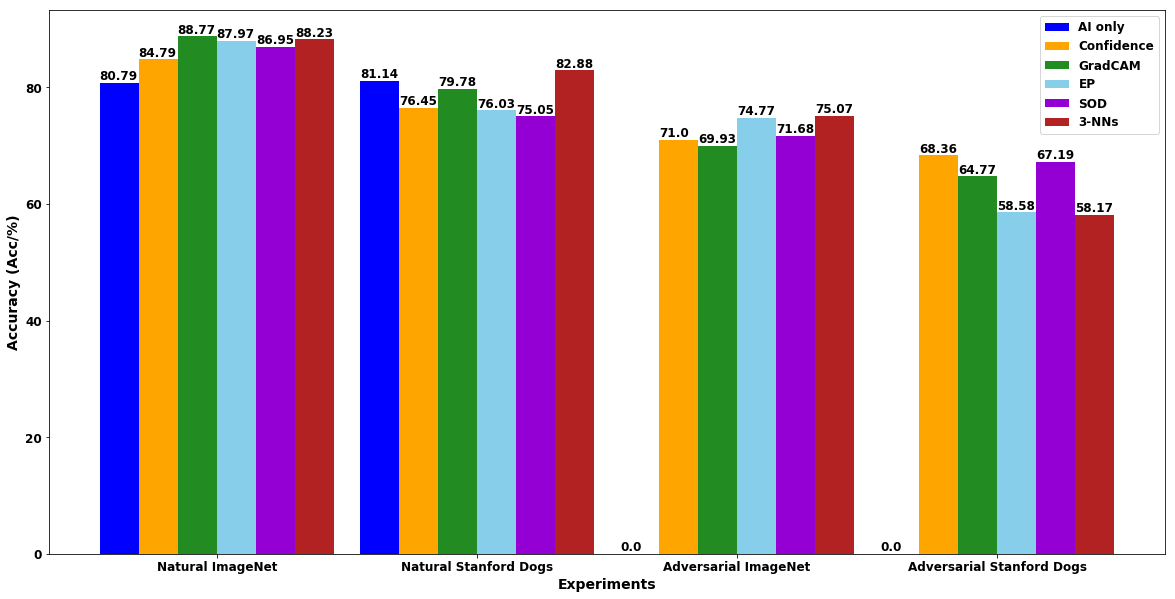

In [6]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt# Declaring the figure or the plot (y, x) or (width, height)
import matplotlib

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.figure(figsize=[20, 10])# Data to be plotted
Natural_ImageNet_acc = [80.79, 84.79, 88.77, 87.97, 86.95, 88.23]
Natural_Dogs_acc = [81.14, 76.45, 79.78, 76.03, 75.05, 82.88]
Adversarial_ImageNet_acc = [0.0, 71.00, 69.93, 74.77, 71.68, 75.07]
Adversarial_Dogs_acc = [0.0, 68.36, 64.77, 58.58, 67.19, 58.17]

Autonomous_AI = [Natural_ImageNet_acc[0], Natural_Dogs_acc[0], Adversarial_ImageNet_acc[0], Adversarial_Dogs_acc[0]]
Confidence = [Natural_ImageNet_acc[1], Natural_Dogs_acc[1], Adversarial_ImageNet_acc[1], Adversarial_Dogs_acc[1]]
GradCAM = [Natural_ImageNet_acc[2], Natural_Dogs_acc[2], Adversarial_ImageNet_acc[2], Adversarial_Dogs_acc[2]]
EP = [Natural_ImageNet_acc[3], Natural_Dogs_acc[3], Adversarial_ImageNet_acc[3], Adversarial_Dogs_acc[3]]
SOD = [Natural_ImageNet_acc[4], Natural_Dogs_acc[4], Adversarial_ImageNet_acc[4], Adversarial_Dogs_acc[4]]
NNs = [Natural_ImageNet_acc[5], Natural_Dogs_acc[5], Adversarial_ImageNet_acc[5], Adversarial_Dogs_acc[5]]

X = np.arange(len(Autonomous_AI))# Passing the parameters to the bar function, this is the main function which creates the bar plot
# Using X now to align the bars side by side


plt.bar(X, Autonomous_AI, color = 'blue', width = 0.15)
plt.bar(X + 0.15, Confidence, color = 'orange', width = 0.15)
plt.bar(X + 0.30, GradCAM, color = 'forestgreen', width = 0.15)
plt.bar(X + 0.45, EP, color = 'skyblue', width = 0.15)
plt.bar(X + 0.60, SOD, color = 'darkviolet', width = 0.15)
plt.bar(X + 0.75, NNs, color = 'firebrick', width = 0.15)

for i in range(len(Autonomous_AI)):
    plt.annotate(Autonomous_AI[i], (-0.075 + i, Autonomous_AI[i]), va='bottom')
    plt.annotate(Confidence[i], (-0.075 + i + 0.15, Confidence[i]), va='bottom')
    plt.annotate(GradCAM[i], (-0.075 + i + 0.30, GradCAM[i]), va='bottom')
    plt.annotate(EP[i], (-0.075 + i + 0.45, EP[i]), va='bottom')
    plt.annotate(SOD[i], (-0.075 + i + 0.60, SOD[i]), va='bottom')
    plt.annotate(NNs[i], (-0.075 + i + 0.75, NNs[i]), va='bottom')

# plt.legend(['Natural ImageNet', 'Natural Stanford Dogs', 'Adversarial ImageNet', 'Adversarial Stanford Dogs'])# Overiding the x axis with the country names
# plt.xticks([i + 0.3 for i in range(6)], ['Autonomous AI', 'Confidence', 'GradCAM', 'EP', 'SOD', '3-NNs'])# Giving the tilte for the plot

plt.legend(['AI only', 'Confidence', 'GradCAM', 'EP', 'SOD', '3-NNs'])# Overiding the x axis with the country names
plt.xticks([i + 0.375 for i in range(4)], ['Natural ImageNet', 'Natural Stanford Dogs', 'Adversarial ImageNet', 'Adversarial Stanford Dogs'])# Giving the tilte for the plot

# plt.style.use('default')
# plt.rcParams['text.usetex'] = True

# plt.title("Human accuracy")# Namimg the x and y axis
plt.xlabel('Experiments', fontsize=14, weight='bold')
plt.ylabel('Accuracy (Acc/%)', fontsize=14, weight='bold')# 
plt.savefig('tmp/accuracy_random.jpeg',dpi=600, format='jpeg', bbox_inches='tight')
plt.show()

# dang annotate cac bars